In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE1 = 113
IMAGE_SIZE2 = 150
CHANNELS=3
EPOCHS=15

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/FINAL_DATASET_CROP_MONITORING",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE1,IMAGE_SIZE2),
    batch_size=BATCH_SIZE
)

Found 3023 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['CMV', 'HEALTHY', 'SIGATOKA']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 113, 150, 3)
[0 0 2 2 0 0 2 2 0 0 0 0 2 0 2 2 2 0 2 2 1 1 2 1 0 0 2 1 0 1 1 0]


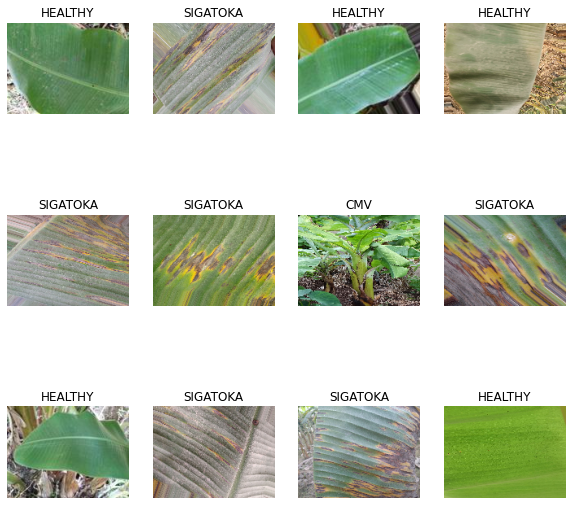

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## **Dividing the dataset into train,test and validation datasets**

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
train_ds

<TakeDataset element_spec=(TensorSpec(shape=(None, 113, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import numpy as np
labels=[]
array1 = np.array([])
for image_batch, labels_batch in test_ds:
  labels.append(labels_batch.numpy())
for i in range(10):
  array1=np.append(array1,labels[i])
lable_list=array1.tolist()


In [ ]:
len(lable_list)

320

In [ ]:
len(test_ds)

10

## **Performing rescaling and resizing**

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE1, IMAGE_SIZE2),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### **Feeding the dataset into the model**

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE1, IMAGE_SIZE2, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 113, 150, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 111, 148, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 146, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (32, 54, 73, 64)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 71, 64)          36928     
                                                                 
 conv2d_3 (Conv2D)           (32, 50, 69, 64)          36928     
                                                      

### **Compiling the model**

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
76/76 [==============================] - 257s 2s/step - loss: 0.6727 - accuracy: 0.7064 - val_loss: 0.4240 - val_accuracy: 0.8507
Epoch 2/15
76/76 [==============================] - 4s 52ms/step - loss: 0.4206 - accuracy: 0.8484 - val_loss: 0.2866 - val_accuracy: 0.8924
Epoch 3/15
76/76 [==============================] - 4s 51ms/step - loss: 0.3203 - accuracy: 0.8803 - val_loss: 0.3028 - val_accuracy: 0.8819
Epoch 4/15
76/76 [==============================] - 4s 51ms/step - loss: 0.3208 - accuracy: 0.8845 - val_loss: 0.2798 - val_accuracy: 0.8958
Epoch 5/15
76/76 [==============================] - 4s 52ms/step - loss: 0.2810 - accuracy: 0.8923 - val_loss: 0.2302 - val_accuracy: 0.9097
Epoch 6/15
76/76 [==============================] - 4s 51ms/step - loss: 0.2371 - accuracy: 0.9159 - val_loss: 0.2041 - val_accuracy: 0.9167
Epoch 7/15
76/76 [==============================] - 4s 52ms/step - loss: 0.2174 - accuracy: 0.9230 - val_loss: 0.1363 - val_accuracy: 0.9514
Epoch 8/15
76

In [ ]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 0s 25ms/step - loss: 0.1056 - accuracy: 0.9781


first image to predict
actual label: SIGATOKA
predicted label: SIGATOKA


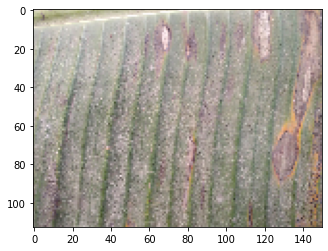

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):

    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

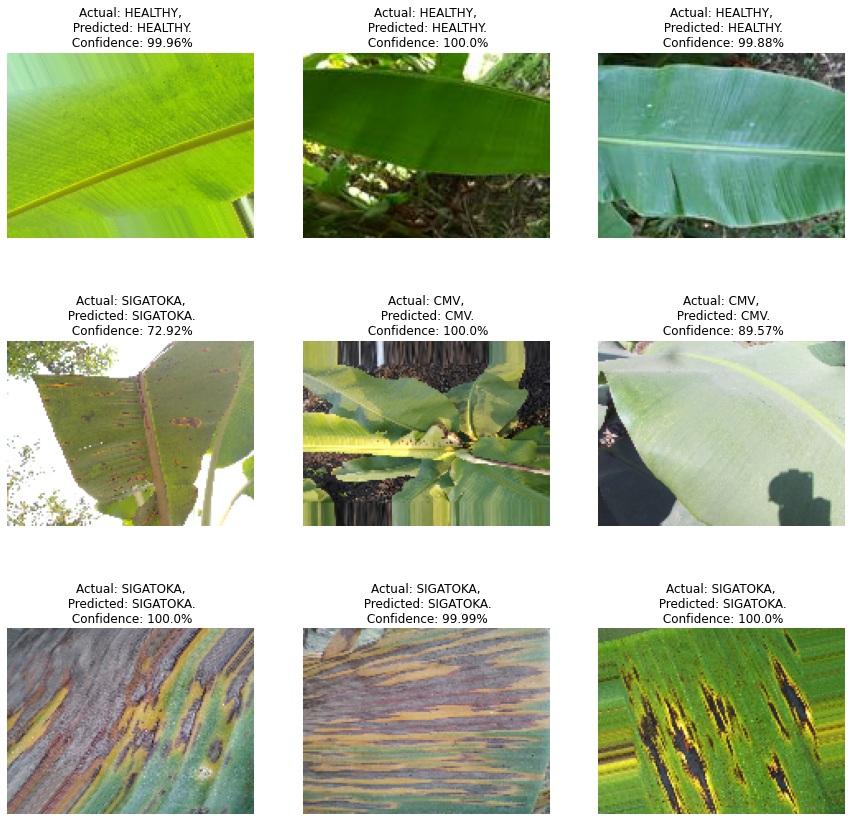

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/FINAL_MODEL_CROP_MONITORING/") + [0]])+1
model.save(f"/content/drive/MyDrive/FINAL_MODEL_CROP_MONITORING/{model_version}")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FINAL_MODEL_CROP_MONITORING/6/assets


In [ ]:
history.params

{'epochs': 15, 'steps': 76, 'verbose': 1}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

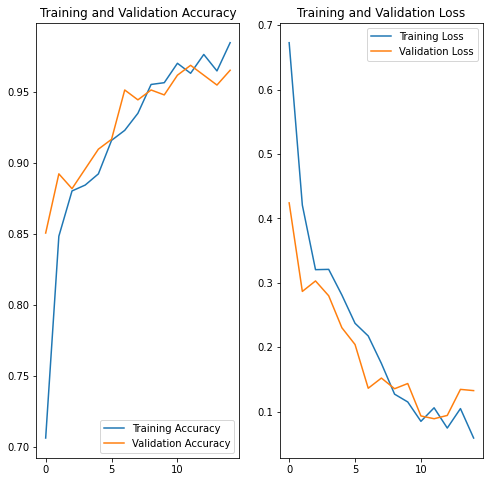

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/FINAL_MODEL_CROP_MONITORING/5')

In [ ]:
#from PIL import Image
from keras.preprocessing.image import img_to_array
import tensorflow as tf
from keras.preprocessing.image import load_img
import numpy as np
import os
#/content/drive/MyDrive/UNTRAINED DATA/UNTRAINED_SIGATOKA.jpg
for image in os.listdir("/content/drive/MyDrive/UNTRAINED_DATA"):
  #img = load_img(image)
  # print("/content/drive/MyDrive/UNTRAINED_DATA"+image)
   #img=img.resize((113,150))
   print(image)
   img = load_img("/content/drive/MyDrive/UNTRAINED_DATA/"+image)
   img=img.resize((150,113))
   img_array = tf.keras.preprocessing.image.img_to_array(img)
   img_array = tf.expand_dims(img_array, 0)
   print(np.argmax(model.predict(img_array)))

UNTRAINED_CMV.jpeg
1
UNTRAINED_SIGATOKA.jpg
0
UNTRAINED_SIGATOKA_1.jpg
0
sigatoka_images.jpg
2
yellow-sigatoka-banana-1563270070.jpg
1
yellow-sigatoka-banana-1563270133.jpg
2
yellow-sigatoka-banana-1563270070 (1).jpg
1
healthy (1).jpg
1
healthy.jpg
1
unknown.jpg
1
cmv_6.jpeg
0
cmv_5.jpeg
1
cmv_4.jpeg
0
cmv_3.jpeg
0
cmv_2.jpeg
0
cmv_1.jpeg
0


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred=model.predict(test_ds)


In [ ]:
np.argmax(y_pred[300])

2

In [ ]:
labels_predicted=[]
for y in y_pred:
  labels_predicted.append(np.argmax(y))

In [ ]:
labels_predicted

In [ ]:
labels_predicted[300]

2

In [ ]:
len(labels_predicted)

320

In [ ]:
for i in range(320):
  lable_list[i] = int(lable_list[i])

In [ ]:
lable_list

In [ ]:
cm = confusion_matrix(lable_list, labels_predicted)

In [ ]:
cm

array([[49, 31, 27],
       [32, 40, 25],
       [20, 33, 63]])

In [ ]:
import pandas as pd
cm_df = pd.DataFrame(cm,
                     index = ['CMV','HEALTHY','SIGATOKA'],
                     columns = ['CMV','HEALTHY','SIGATOKA'])

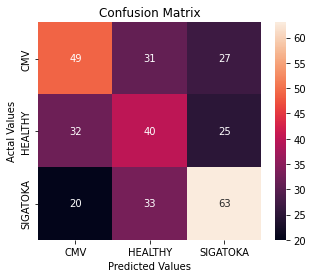

In [ ]:
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()